In [2]:
import os
import shutil
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F

import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [1]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 53.8 MB/s eta 0:00:00:00:0100:01


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 이미지 불러오기

In [4]:
# 원본 데이터 경로 (압축 해제 후 폴더)
images_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Images')   # 이미지들이 위치한 폴더
mat_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map')   # 프로젝트 루트 디렉토리

# .mat 파일 경로 (train_list.mat와 test_list.mat가 각각 같은 구조라고 가정)
train_mat_path = os.path.join(mat_dir, 'train_list.mat')
test_mat_path = os.path.join(mat_dir, 'test_list.mat')

# .mat 파일 로드
train_mat = sio.loadmat(train_mat_path)
test_mat = sio.loadmat(test_mat_path)

# train_mat와 test_mat 내부에 'file_list'와 'labels' 등이 있음
train_file_list = train_mat['file_list']
train_labels = train_mat['labels'].squeeze()  # (N,)
test_file_list = test_mat['file_list']
test_labels = test_mat['labels'].squeeze()

# 최종적으로 ImageFolder 구조로 재구성할 대상 폴더 생성 (예: stanford_dogs/train, stanford_dogs/test)
base_dir = 'stanford_dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def process_mat_file(file_list_array, split_dir):
    """
    .mat 파일에서 로드한 file_list_array를 사용해,
    split_dir(예: train 혹은 test)에 클래스별 폴더를 생성하고 이미지를 복사합니다.
    """
    num_files = file_list_array.shape[0]
    for idx in range(num_files):
        # file_list_array[idx]는 보통 array([<파일경로>]) 형태입니다.
        # 따라서, array([<파일경로>]).item()을 사용하면 실제 문자열을 얻을 수 있습니다.
        file_path = file_list_array[idx][0].item()

        # 혹시 bytes 타입이면 문자열로 디코딩
        if isinstance(file_path, bytes):
            file_path = file_path.decode('utf-8')

        # 파일 경로 예시: 'n02116738-African_hunting_dog/n02116738_2988.jpg'
        # 클래스 이름은 파일 경로의 최상위 폴더명 (예: 'n02116738-African_hunting_dog')
        class_folder = file_path.split('/')[0]

        # 대상 클래스 폴더 생성
        dest_folder = os.path.join(split_dir, class_folder)
        os.makedirs(dest_folder, exist_ok=True)

        # 원본 이미지 경로: Images 폴더 아래에 file_path 위치
        src_path = os.path.join(images_dir, file_path)
        # 대상 이미지 경로: dest_folder 아래에 원본 파일명 그대로 복사
        dest_path = os.path.join(dest_folder, os.path.basename(file_path))

        # 파일 존재 여부 확인 후 복사
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"File not found: {src_path}")

print("Processing train set...")
process_mat_file(train_file_list, train_dir)
print("Processing test set...")
process_mat_file(test_file_list, test_dir)

print("Dataset reorganization complete.")

Processing train set...
Processing test set...
Dataset reorganization complete.


In [5]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 경로 (재구성한 ImageFolder 형식)
train_dir = os.path.join('stanford_dogs', 'train')
test_dir = os.path.join('stanford_dogs', 'test')
# Annotation 폴더 경로 (예: '/root/Annotation')
annotation_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Annotation')

# 커스텀 데이터셋 생성: image, label, bbox 반환
train_dataset = StanfordDogsDatasetWithBBox(root=train_dir, annotation_root=annotation_dir, transform=transform)
valid_dataset = StanfordDogsDatasetWithBBox(root=test_dir, annotation_root=annotation_dir, transform=transform)

batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(valid_dataset)}")

Number of classes: 120
Train samples: 12000
Test samples: 8580


In [7]:
train_dataset.classes

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [8]:
dog_name_list = [s.split('-', 1)[1] for s in train_dataset.classes]
print(dog_name_list)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'cur

In [9]:
def visualize(sample):
    img_tensor, label, bbox = sample

    # 인덱스와 클래스 정보
    print("Label index:", label)
    print("Class name:", train_dataset.classes[label])

    # 정규화 복원 전처리 시 사용한 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # tensor의 shape: (C, H, W) -> (H, W, C)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    plt.title(f"Class: {train_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

Label index: 0
Class name: n02085620-Chihuahua


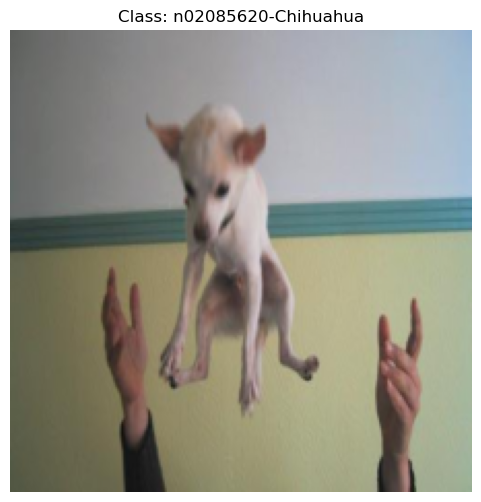

In [10]:
# 임의의 한 샘플 선택 (여기서는 첫 번째 샘플을 사용)
train_sample = train_dataset[0]

visualize(train_sample)

Label index: 0
Class name: n02085620-Chihuahua


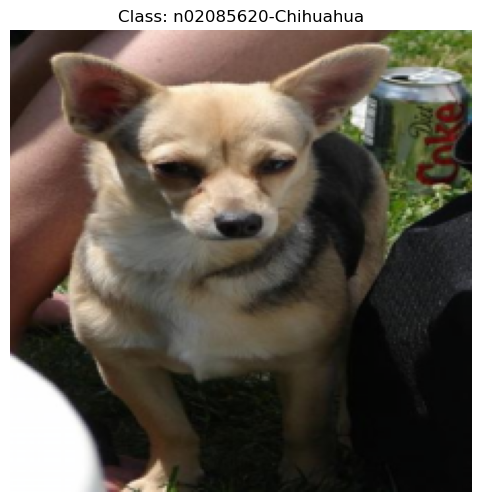

In [11]:
# 임의의 한 샘플 선택 (여기서는 첫 번째 샘플을 사용)
test_sample = valid_dataset[0]

visualize(test_sample)

In [12]:
# Annotation 폴더에서 데이터를 골라보세요
annotation_path = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Annotation/n02085620-Chihuahua/n02085620_10074')


# XML 파일 파싱
tree = ET.parse(annotation_path)
root = tree.getroot()

for elem in root.iter():
    print(f"{elem.tag}: {elem.text}")

annotation: 
	
folder: 02085620
filename: n02085620_10074
source: 
		
database: ImageNet database
size: 
		
width: 333
height: 500
depth: 3
segment: 0
object: 
		
name: Chihuahua
pose: Unspecified
truncated: 0
difficult: 0
bndbox: 
			
xmin: 25
ymin: 10
xmax: 276
ymax: 498


## 모델 구현 및 학습

In [13]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2):
    best_acc = 0.0
    patience = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"\nEpoch {epoch+1}/{num_epochs} 시작")
        for batch_idx, (images, labels, _) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            if (batch_idx + 1) % 50 == 0:
                print(f"  Step {batch_idx+1} - Loss: {loss.item():.4f}")

        train_loss = running_loss / (batch_idx + 1)
        train_acc = correct / total
        print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

        # 검증 단계
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        test_loss = running_loss / len(valid_loader)
        test_acc = correct / total
        print(f"Validation - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

        if best_acc < test_acc:
            best_acc = test_acc
            patience = 0
            # 모델 저장
            print("Saved model")
            cam_model_path = os.path.join(os.getenv("HOME"), "work/class_activation_map/cam_model2.pt")
            torch.save(model, cam_model_path)

        else:
            patience +=1

        if patience >= 5:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            

In [41]:
%%time

train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20)


Epoch 1/20 시작
  Step 50 - Loss: 4.8445
  Step 100 - Loss: 4.2034
  Step 150 - Loss: 3.2856
  Step 200 - Loss: 3.0100
  Step 250 - Loss: 2.2897
  Step 300 - Loss: 2.7163
  Step 350 - Loss: 2.1701
  Step 400 - Loss: 1.7114
  Step 450 - Loss: 2.1376
  Step 500 - Loss: 1.6246
  Step 550 - Loss: 1.2692
  Step 600 - Loss: 1.2268
  Step 650 - Loss: 1.4400
  Step 700 - Loss: 1.2267
  Step 750 - Loss: 1.0919
  Step 800 - Loss: 1.0166
  Step 850 - Loss: 1.1140
  Step 900 - Loss: 1.3676
  Step 950 - Loss: 1.5266
  Step 1000 - Loss: 1.2421
Train - Loss: 2.1178, Accuracy: 53.49%
Validation - Loss: 0.7626, Accuracy: 77.21%
Saved model

Epoch 2/20 시작
  Step 50 - Loss: 1.2016
  Step 100 - Loss: 1.3131
  Step 150 - Loss: 0.8131
  Step 200 - Loss: 0.8020
  Step 250 - Loss: 1.2505
  Step 300 - Loss: 0.3078
  Step 350 - Loss: 0.9141
  Step 400 - Loss: 0.9843
  Step 450 - Loss: 0.6692
  Step 500 - Loss: 0.8126
  Step 550 - Loss: 1.0722
  Step 600 - Loss: 0.6085
  Step 650 - Loss: 0.4995
  Step 700 - Loss:

# CAM 구현하기

In [15]:
def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

In [16]:
def generate_cam(model, image, dog_name_list):
    # hook을 통해 fc weight 불러오기
    # last layer activation map 불러오기
    
    model.eval()
    features = []
    
    def hook(module, input, output):
        features.append(output.detach())

    hook_handle = model.layer4.register_forward_hook(hook)

    output = model(image)
    hook_handle.remove()

    predicted_class = output.argmax(dim=1).item()
    predicted_dog_name = dog_name_list[predicted_class]

    class_scores = model.fc.weight.data.to(image.device)
    

    activation_map = features[0][0]
    cam_image = torch.zeros(activation_map.shape[1:], dtype=torch.float32, device=image.device)

    # fc 가중치와 feature map의 각 채널을 가중합
    for i, w in enumerate(class_scores[predicted_class]):
        cam_image += w * activation_map[i, :, :]
    cam_image = cam_image.cpu().numpy()

    # CAM 정규화
    cam_image = np.maximum(cam_image, 0)
    cam_image = (cam_image - np.min(cam_image)) / (np.max(cam_image) - np.min(cam_image) + 1e-8)
        

    return cam_image, predicted_dog_name

In [17]:
def visualize_cam(cam):
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.title("CAM")
    plt.axis('off')
    plt.show()

def visualize_cam_on_image(cam, img, dog_name, pred_dog, alpha=0.5):
    # CAM 크기를 원본 이미지 크기로 조정
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # CAM을 컬러 heatmap으로 변환 (cv2.applyColorMap는 BGR로 반환하므로 RGB로 변경)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 heatmap을 alpha blending
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title(f"Ground Truth: {dog_name}, Predict: {pred_dog}")
    plt.axis('off')
    plt.show()

In [18]:
cam_model_path = os.path.join(os.getenv("HOME"), "work/class_activation_map/cam_model2.pt")
model = torch.load(cam_model_path, weights_only=False)

In [19]:
image, label, ground_bbox = train_dataset[10]
dog_name = dog_name_list[label]
sample_image = image.unsqueeze(0).to(device)


In [20]:
cam_image, pred_dog = generate_cam(model, sample_image, dog_name_list)

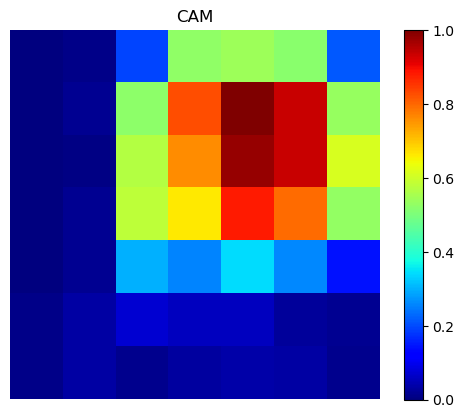

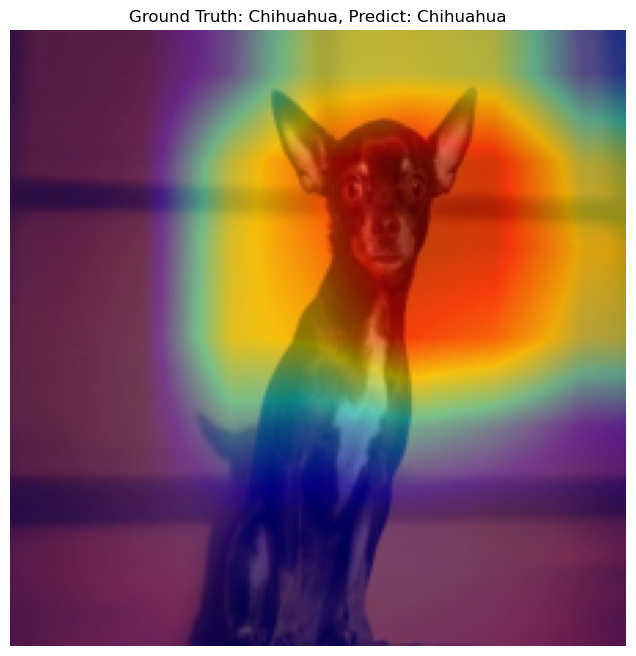

In [21]:
# 원본 이미지 복원
orig_img = unnormalize(image)

# CAM 단독 시각화
visualize_cam(cam_image)

# 원본 이미지 위에 CAM overlay 시각화
visualize_cam_on_image(cam_image, orig_img, dog_name, pred_dog)

# Grad-CAM 구현하기

In [22]:
def generate_grad_cam(model, dog_name_list, activation_layer, image):
    # activation layer 이름을 받아 feature map과 gradient 받아오기

    model.eval()
    features = {}
    gradients = {}

    def forward_hook(module, input, output):
        features['value'] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 모델 내에서 이름이 activation_layer과 일치하는 레이어 검색
    target_layer = dict(model.named_modules()).get(activation_layer, None)
    if target_layer is None:
        raise ValueError(f"Layer '{activation_layer}' not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    output = model(image)
    predicted_class = output.argmax(dim=1).item()
    predicted_dog_name = dog_name_list[predicted_class]
    
    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, predicted_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    activation_map = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam_image = torch.zeros(activation_map.shape[1:], dtype=torch.float32, device=activation_map.device)
    for i, w in enumerate(weights):
        grad_cam_image += w * activation_map[i, :, :]
    grad_cam_image = grad_cam_image.cpu().numpy()

    # ReLU 적용 및 정규화: 음수 값 제거 및 [0,1] 범위로 스케일링
    grad_cam_image = np.maximum(grad_cam_image, 0)
    grad_cam_image = (grad_cam_image - grad_cam_image.min()) / (grad_cam_image.max() - grad_cam_image.min() + 1e-8)
        

        
    return grad_cam_image, predicted_dog_name

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


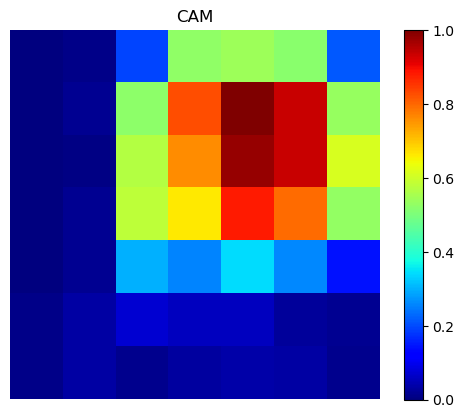

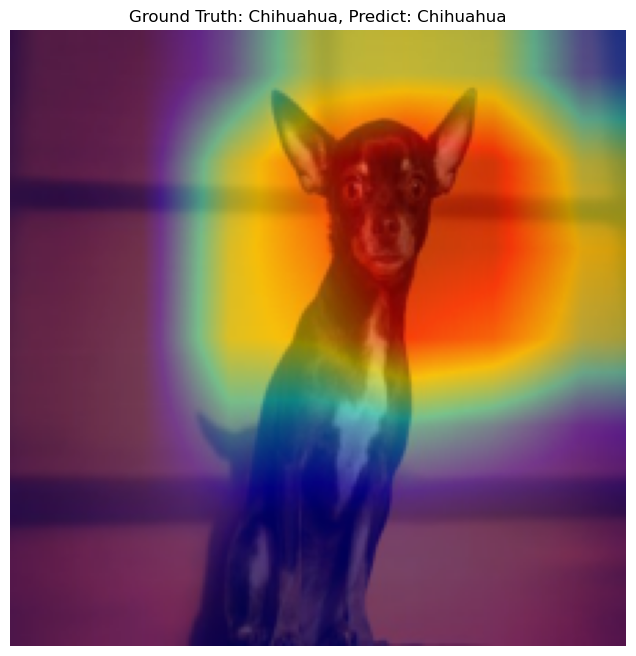

In [23]:
# layer4 사용
grad_cam_image, pred_dog = generate_grad_cam(model, dog_name_list, activation_layer="layer4", image=sample_image)

# Grad-CAM 단독 시각화
visualize_cam(grad_cam_image)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)

visualize_cam_on_image(grad_cam_image, orig_img, dog_name, pred_dog)

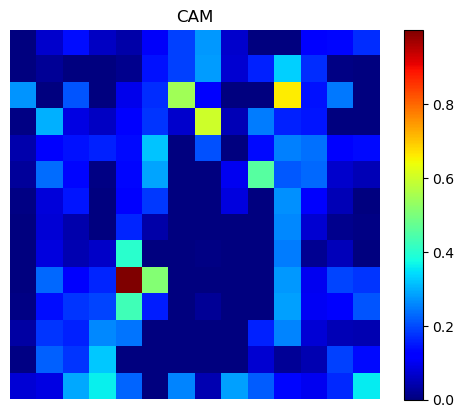

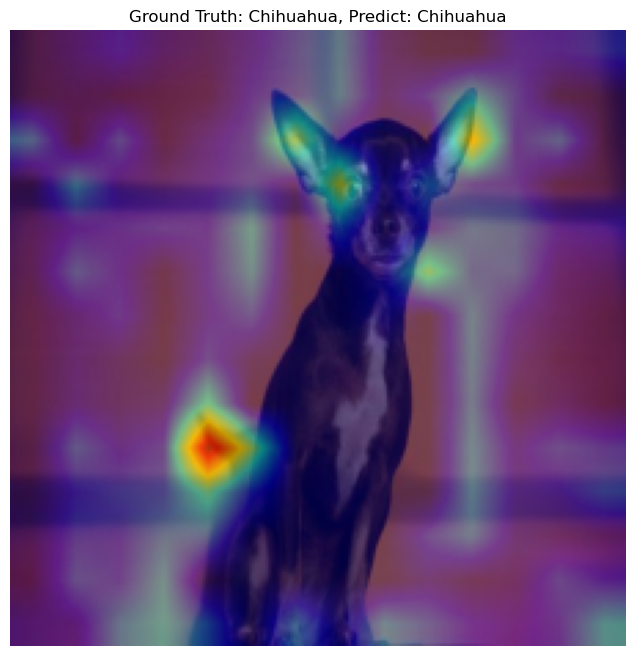

In [24]:
grad_cam_image, pred_dog = generate_grad_cam(model, dog_name_list, activation_layer="layer3", image=sample_image)

# Grad-CAM 단독 시각화
visualize_cam(grad_cam_image)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam_image, orig_img, dog_name, pred_dog)

# 바운딩 박스 구하기

In [25]:
def get_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None
    # np.argwhere의 결과는 (row, col) 즉, (y, x) 순서입니다.
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

In [26]:
cam_resized = cv2.resize(cam_image, (orig_img.shape[1], orig_img.shape[0]))
cam_pred_bbox = get_bbox(cam_resized, threshold=0.5)

grad_cam_resized = cv2.resize(grad_cam_image, (orig_img.shape[1], orig_img.shape[0]))
grad_cam_pred_bbox = get_bbox(grad_cam_resized, threshold=0.5)

print('CAM bbox: ', cam_pred_bbox)
print('Grad-CAM bbox: ', grad_cam_pred_bbox)

CAM bbox:  (np.int64(75), np.int64(0), np.int64(223), np.int64(133))
Grad-CAM bbox:  (np.int64(63), np.int64(33), np.int64(172), np.int64(165))


In [27]:
def visualize_bbox_on_image(img, bbox, box_color=(255, 0, 0), thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), box_color, thickness)
    else:
        print("활성화된 영역이 없습니다.")
    return img_with_bbox

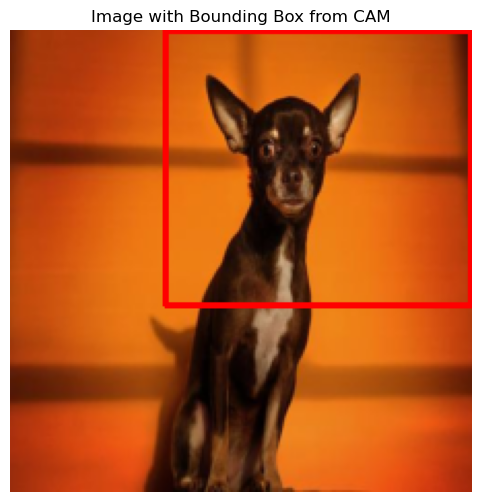

In [28]:
img_bbox = visualize_bbox_on_image(orig_img, cam_pred_bbox)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Image with Bounding Box from CAM")
plt.axis("off")
plt.show()

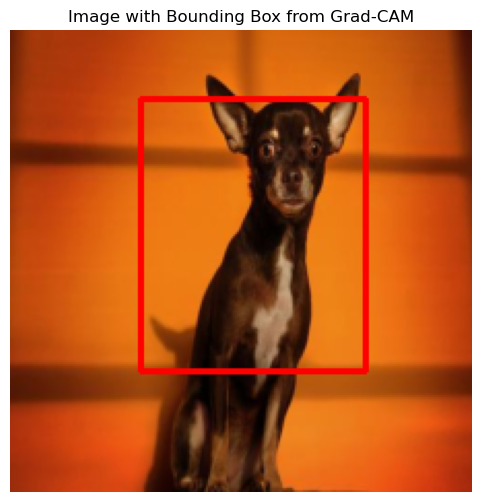

In [29]:
img_bbox = visualize_bbox_on_image(orig_img, grad_cam_pred_bbox)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Image with Bounding Box from Grad-CAM")
plt.axis("off")
plt.show()

# IoU 구하기

In [30]:
def get_iou(gt_bbox, pred_bbox):
    # bbox 중 하나라도 None이면 IoU 0.0
    if gt_bbox is None or pred_bbox is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = gt_bbox
    x_min2, y_min2, x_max2, y_max2 = pred_bbox

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

In [31]:
cam_iou = get_iou(ground_bbox, cam_pred_bbox)
print('CAM IoU: ', cam_iou)

grad_cam_iou = get_iou(ground_bbox, grad_cam_pred_bbox)
print('Grad-CAM IoU: ', grad_cam_iou)

CAM IoU:  0.3721396565303057
Grad-CAM IoU:  0.576736758979163


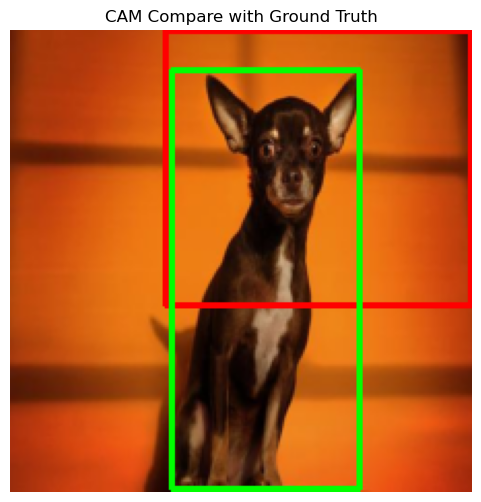

In [32]:
def visualize_both_bbox_on_image(img, bbox, ground_truth, thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()

    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness)

    x_min_t, y_min_t, x_max_t, y_max_t = ground_truth
    cv2.rectangle(img_with_bbox, (x_min_t, y_min_t), (x_max_t, y_max_t), (0, 255, 0), thickness)

    return img_with_bbox

ground_truth = [int(x) for x in ground_bbox]

img_bbox = visualize_both_bbox_on_image(orig_img, cam_pred_bbox, ground_truth)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("CAM Compare with Ground Truth")
plt.axis("off")
plt.show()

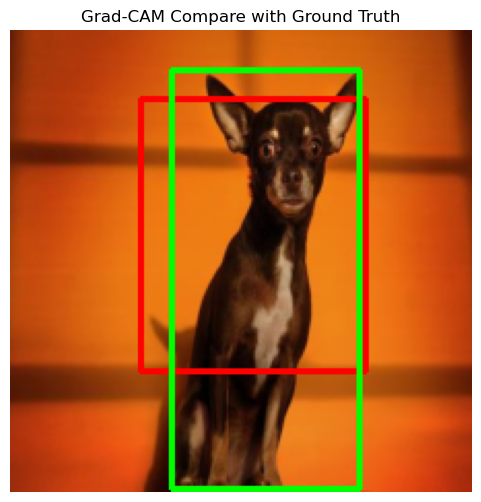

In [33]:
img_bbox = visualize_both_bbox_on_image(orig_img, grad_cam_pred_bbox, ground_truth)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Grad-CAM Compare with Ground Truth")
plt.axis("off")
plt.show()

마지막 convolution layer 이후, GAP과 fully-connected layer를 통과하여 class를 예측하기 때문에 CAM과 Grad-CAM은 동일한 결과를 생성해야 한다.   
CAM과 Grad-CAM 간의 heatmap, bounding box, IoU 를 비교하면 동일한 값을 갖는 것을 확인할 수 있다.   

CAM과 Grad-CAM은 XAI 기법으로, 학습된 모델의 예측 근거를 살펴보며 모델의 문제점과 개선점을 파악할 수 있다. 대표적으로 다양한 객체 크기에 따른 분류 성능과 class activation map을 살펴볼 수 있을 것이다.

### object scale에 따른 분석

#### 멀리 있는 보더콜리 사진

이미지 크기: (285, 431, 3)


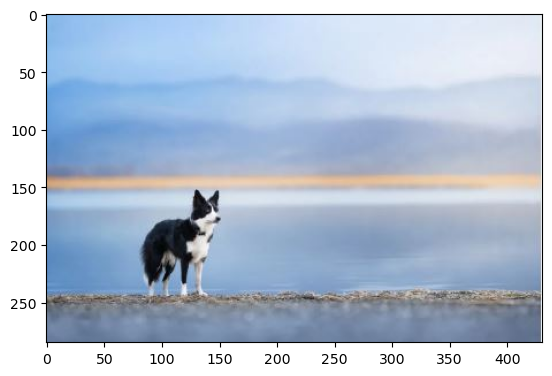

In [34]:
img_path = os.path.join(os.getenv("HOME"), "work/AIFFEL_quest_rs/GoingDeeper/Deeper01/deeper01_img10.JPG")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

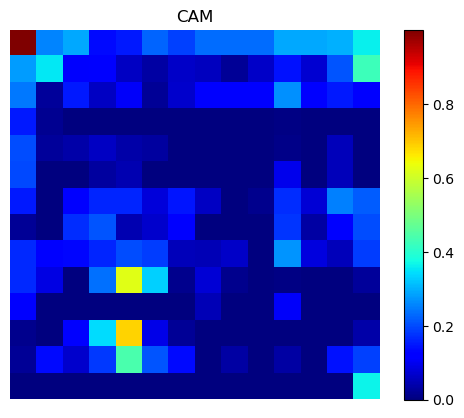

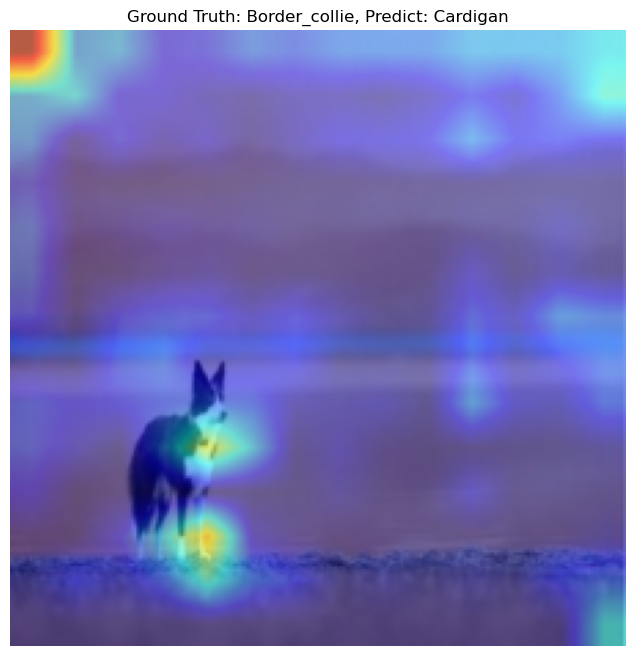

In [36]:
image = transform(img_orig)
sample_image = image.unsqueeze(0).to(device)

# layer4 사용
grad_cam_image, pred_dog = generate_grad_cam(model, dog_name_list, activation_layer="layer3", image=sample_image)

# Grad-CAM 단독 시각화
visualize_cam(grad_cam_image)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)

visualize_cam_on_image(grad_cam_image, orig_img, 'Border_collie', pred_dog)

#### 가까이 있는 보더콜리 사진

이미지 크기: (128, 194, 3)


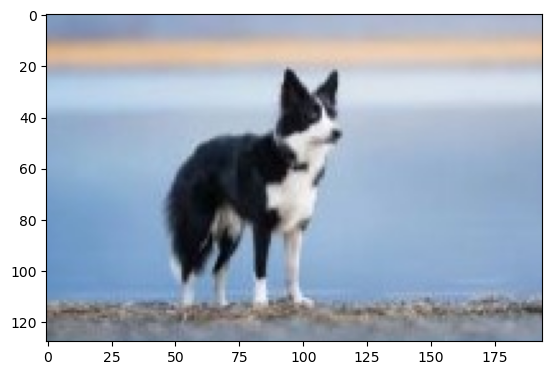

In [37]:
img_path = os.path.join(os.getenv("HOME"), "work/AIFFEL_quest_rs/GoingDeeper/Deeper01/deeper01_img11.JPG")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

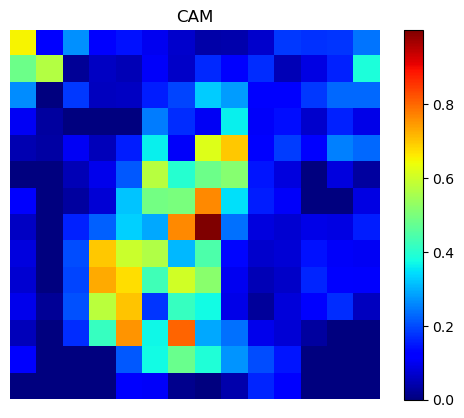

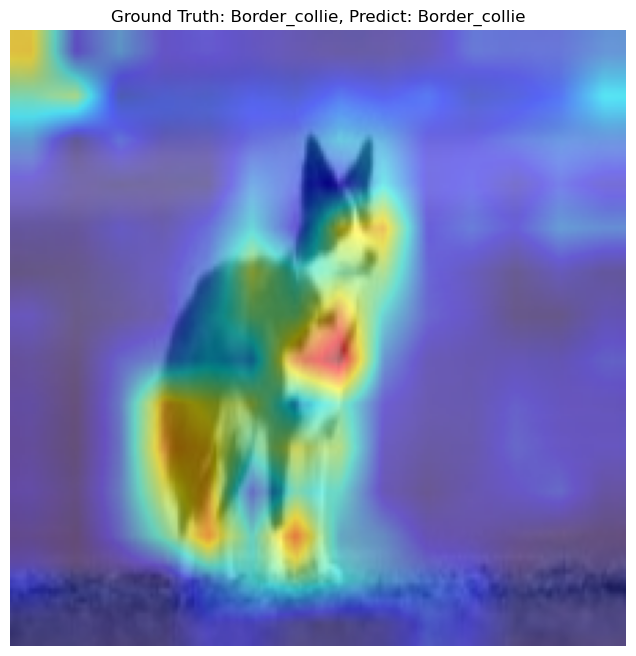

In [38]:
image = transform(img_orig)
sample_image = image.unsqueeze(0).to(device)

# layer4 사용
grad_cam_image, pred_dog = generate_grad_cam(model, dog_name_list, activation_layer="layer3", image=sample_image)

# Grad-CAM 단독 시각화
visualize_cam(grad_cam_image)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)

visualize_cam_on_image(grad_cam_image, orig_img, 'Border_collie', pred_dog)

- 상대적으로 객체의 크기가 작은 이미지의 경우 보더콜리를 Cardigan으로 잘못 예측한 반면에 객체의 크기가 큰 경우 보더콜리로 올바르게 예측한 것을 확인할 수 있었다.
- 객체의 크기가 작은 경우의 activation map을 살펴볼때, 배경이 활성화되지 않고 객체가 존재하는 부위에 활성화가 되어있다. 즉, 객체와 전혀 관련없는 영역에 편향되어 예측했다기 보다 객체로부터 세부적인 정보를 학습하지 못해 오분류를 했다고 생각해 볼 수 있다.
- 이는 초기 layer의 max pooling과 conv layer의 stride를 조정함으로써 작은 영역을 더 세밀하게 특징을 포착할 수 있도록 하여 문제를 개선해볼 수 있을 것이다.